In [1]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random

In [2]:
source = os.path.join('MOT', 'test')
verbose = False
tests = ['test1', 'test2', 'test3', 'test4']

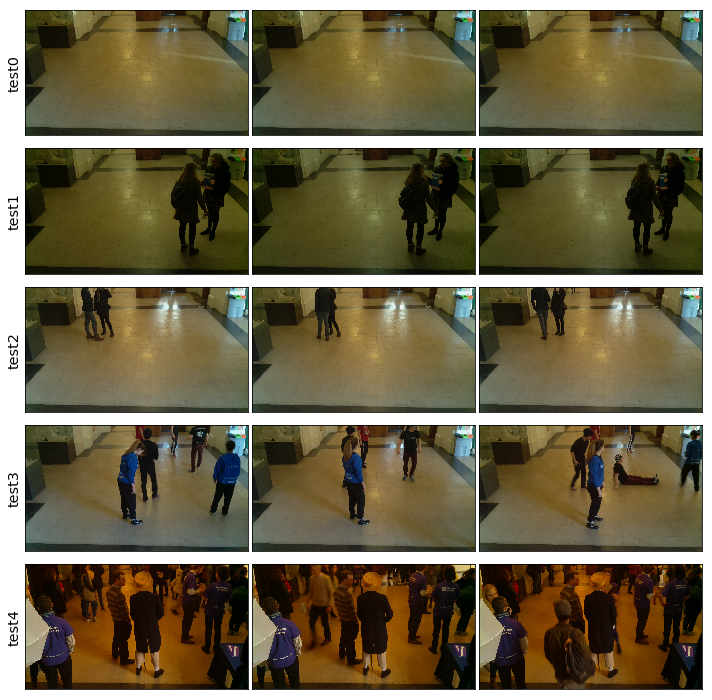

In [6]:
# Get example frames
test_paths = os.listdir(source)
test_paths = sorted([p for p in test_paths if p[:4] == 'test'])

rows = len(test_paths)
cols = 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 2*rows)) 

for row, test_path in enumerate(test_paths):
    img1_path = os.path.join(source, test_path, 'img1')
    image_paths = sorted(os.listdir(img1_path))
    image_paths = [p for p in image_paths if p[-4:] == '.jpg']
    choice = random.randrange(len(image_paths) - cols)
    for col in range(cols):
        image_path = image_paths[choice + col]
        img = cv2.imread(os.path.join(img1_path, image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        axes[row, col].imshow(img)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
for ax, path in zip(axes[:,0], test_paths):
    test_name = os.path.basename(path)
    ax.set_ylabel(test_name, size='x-large')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.02, hspace=0.0)
plt.show()

In [7]:
#fig.savefig('figures/3_1.png', bbox_inches='tight')

In [8]:
# Get det_gt

det_gt_path = 'detections.csv'
with open(det_gt_path, 'r') as f:
  reader = csv.reader(f)
  gt_raw = list(reader)
    
def fill_blanks(_item):
    if _item is '':
        return 0
    return int(_item)

det_gts = []
for test in tests:
    if verbose:
        print('\n\t> {}'.format(test))
    gt = []
    for g in gt_raw[1:]:  # ignore header
        if g[0] == test:
            result = [fill_blanks(r) for r in g[1:]]
            gt.append(result)
            if verbose:
                print(result)
    det_gts.append(gt)

# Get gts
gts = []
for test in tests:
    path = os.path.join(source, test, 'gt', 'gt.csv')
    with open(path, 'r') as f:
      reader = csv.reader(f)
      gts.append(list(reader))
        


In [9]:
print(np.shape(det_gts))
print(np.shape(gts))

(4, 100, 5)
(4,)


In [10]:
# Get ID summaries

fulls_counts = []
partials_counts = []
heavies_counts = []
total_counts = []
ids_counts = []
for test, det in zip(tests, det_gts):
    fulls = []
    partials = []
    heavies = [] 
    for d in det:
        fulls.append(d[2])
        partials.append(d[3])
        heavies.append(d[4])        
    fulls_counts.append(sum(fulls))
    partials_counts.append(sum(partials))
    heavies_counts.append(sum(heavies))
    total_counts.append(sum(fulls) + sum(partials) + sum(heavies))
    
for test, gt in zip(tests, gts):
    ids = []    
    for g in gt:
        ids.append(g[1])      
    unique_ids = set(ids)
    ids_counts.append(len(unique_ids))
    
gt_ped_summary = pd.DataFrame({'tests': tests,
                        'no_occlusion': fulls_counts,
                        'partial_occlusion\n(<50%)': partials_counts,
                        'heavy_occlusion\n(>50%)': heavies_counts,
                        'total_pedestrians': total_counts})
gt_unique_summary = pd.DataFrame({'tests': tests,
                        'unique_pedestrians': ids_counts})
    
gt_ped_summary

,heavy_occlusion (>50%),no_occlusion,partial_occlusion (<50%),tests,total_pedestrians
0,16,22,13,test1,51
1,41,18,54,test2,113
2,196,229,163,test3,588
3,1330,197,494,test4,2021


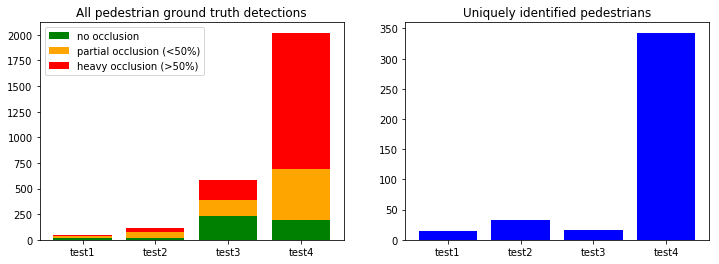

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 

ax1.bar(gt_ped_summary.tests, gt_ped_summary.no_occlusion, color='green')
ax1.bar(gt_ped_summary.tests, gt_ped_summary['partial_occlusion\n(<50%)'], bottom=gt_ped_summary.no_occlusion,
        color='orange')
ax1.bar(gt_ped_summary.tests, gt_ped_summary['heavy_occlusion\n(>50%)'],
        bottom=gt_ped_summary.no_occlusion + gt_ped_summary['partial_occlusion\n(<50%)'],
        color='red')
ax1.legend(['no occlusion', 'partial occlusion (<50%)', 'heavy occlusion (>50%)'])
ax1.set_title('All pedestrian ground truth detections')

ax2.bar(gt_unique_summary.tests, gt_unique_summary.unique_pedestrians,  color='blue')
ax2.set_title('Uniquely identified pedestrians')
plt.show()

In [12]:
#fig.savefig('figures/3_2.png', bbox_inches='tight')